# Xarray and signal alignment

A common usecase for TokSearch is to gather a number of time-dependent signals, $S_i(t)$, and then derive additional time-dependent quantities $S_{derived, j}$:

$$S_{derived, j}(t) = f(S_1(t),...S_i(t))$$

The xarray package provides a convenient mechanism for performing such manipulations. The xarray dataset class allows for easy manipulation of arbitrary-dimension data. For fusion applications, this will usually fall into one of three categories:

1. 0d, time-dependent scalars (e.g. plasma current)
2. 1d, time-dependent profiles (e.g. current profiles)
3. 2d, time-dependent grid data (e.g. flux on the grid)


## Creating a dataset using a  ```Pipeline``` 

The ```Pipeline``` class provides a method, ```fetch_dataset``` for creating and populating a dataset within a ```Record``` object. Here, we will demonstrate this using the same signals as the quickstart guide, but we will substitute ```fetch_dataset``` for ```fetch```. The ```fetch_dataset``` methods takes as input:

1. A label for entire dataset.
2. A dictionary of the form ```{'signal_label': signal_object, ...}```

In [1]:
from toksearch import MdsSignal, Pipeline

def downsample(sig_result):
    """Downsample a signal result by a factor of 4"""
    sig_result["data"] = sig_result["data"][::4]
    sig_result["times"] = sig_result["times"][::4]
    return sig_result

def create_pipeline():
    ip_signal = MdsSignal(r'\ipmeas', 'efit01')
    ipmhd_signal = MdsSignal(r'\ipmhd', 'efit01').set_callback(downsample)
    shots = [165920, 165921]
    pipeline = Pipeline(shots)
    pipeline.fetch_dataset('ds', {'ip': ip_signal, 'ipmhd': ipmhd_signal})
    return pipeline

pipeline = create_pipeline()
records = pipeline.compute_serial()

for record in records:
    print('*'*80)
    print(record)
            

********************************************************************************
{'shot': 165920, 'errors': {}, 'ds': <xarray.Dataset> Size: 4kB
Dimensions:  (shot: 1, times: 303)
Coordinates:
  * shot     (shot) int64 8B 165920
  * times    (times) float32 1kB 100.0 140.0 160.0 ... 6.36e+03 6.38e+03
Data variables:
    ip       (times) float32 1kB 2.109e+05 2.746e+05 ... 4.77e+05 4.709e+05
    ipmhd    (times) float32 1kB 2.135e+05 nan nan nan ... nan 4.753e+05 nan nan}
********************************************************************************
{'shot': 165921, 'errors': {}, 'ds': <xarray.Dataset> Size: 4kB
Dimensions:  (shot: 1, times: 304)
Coordinates:
  * shot     (shot) int64 8B 165921
  * times    (times) float32 1kB 100.0 140.0 160.0 ... 6.36e+03 6.38e+03
Data variables:
    ip       (times) float32 1kB 2.116e+05 2.743e+05 ... 4.866e+05 4.827e+05
    ipmhd    (times) float32 1kB 2.133e+05 nan nan nan ... 4.876e+05 nan nan nan}


Things to note about this result:

- Each ```Record``` has field called ```ds```, as requested in the call to ```fetch_dataset```.
- Both signals in ```ds``` share a timebase (the ```times``` coordinate). However, because ```ipmhd``` has a much slower sample rate, most of its data is filled with NANs.

## Unaligned signals

First, let's visualize the unaligned signals for reference. We'll create a utility function first for convenience.

<xarray.Dataset> Size: 4kB
Dimensions:  (shot: 1, times: 303)
Coordinates:
  * shot     (shot) int64 8B 165920
  * times    (times) float32 1kB 100.0 140.0 160.0 ... 6.36e+03 6.38e+03
Data variables:
    ip       (times) float32 1kB 2.109e+05 2.746e+05 ... 4.77e+05 4.709e+05
    ipmhd    (times) float32 1kB 2.135e+05 nan nan nan ... nan 4.753e+05 nan nan


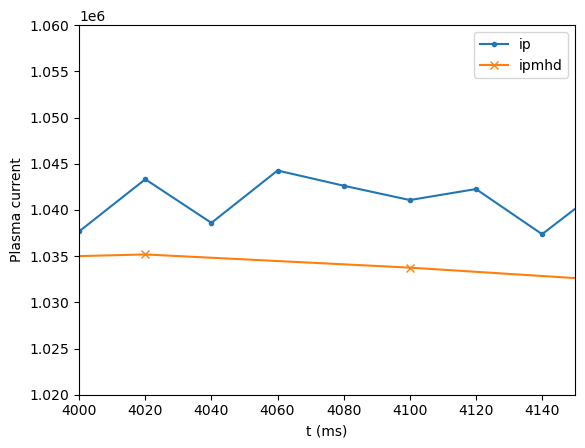

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def compute_and_plot(pipeline, xlim=None, ylim=None):
    rec = pipeline.compute_serial()[0]
    ds = rec['ds']
    print(ds)

    ip = ds.ip.dropna("times")
    ip_mhd = ds.ipmhd.dropna("times")
    
    plt.plot(ip.times, ip, ".-", label='ip')
    plt.plot(ip_mhd.times, ip_mhd, "x-", label='ipmhd')
    plt.xlabel('t (ms)')
    plt.ylabel('Plasma current')
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.legend()

# Align everything in ds with ip using the pad method.
# The pad method looks for the nearest time point in the
# and uses that.
pipeline = create_pipeline()
compute_and_plot(pipeline, xlim=(4000,4150), ylim=(1.02e6, 1.06e6))

## Aligning signals

Suppose that we now want to make sure the ```times``` dimensions for both signals are aligned and have data at each sample (instead of possibly having a NAN).

We accomplish this by using the ```Pipeline.align``` method.

### Using pad (or zero-order hold)

<xarray.Dataset> Size: 4kB
Dimensions:  (shot: 1, times: 303)
Coordinates:
  * shot     (shot) int64 8B 165920
  * times    (times) float32 1kB 100.0 140.0 160.0 ... 6.36e+03 6.38e+03
Data variables:
    ip       (times) float32 1kB 2.109e+05 2.746e+05 ... 4.77e+05 4.709e+05
    ipmhd    (times) float32 1kB 2.135e+05 2.135e+05 ... 4.753e+05 4.753e+05


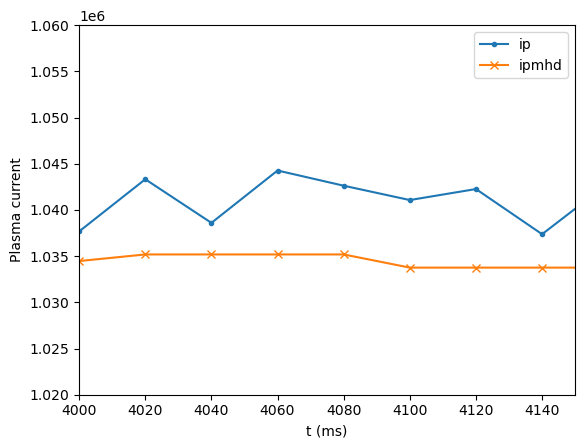

In [10]:
pipeline = create_pipeline()
pipeline.align('ds', 'ip', method='pad')
compute_and_plot(pipeline, xlim=(4000,4150), ylim=(1.02e6, 1.06e6))

### Using linear interpolation


<xarray.Dataset> Size: 4kB
Dimensions:  (shot: 1, times: 303)
Coordinates:
  * shot     (shot) int64 8B 165920
  * times    (times) float32 1kB 100.0 140.0 160.0 ... 6.36e+03 6.38e+03
Data variables:
    ip       (times) float32 1kB 2.109e+05 2.746e+05 ... 4.77e+05 4.709e+05
    ipmhd    (times) float32 1kB 2.135e+05 2.444e+05 ... 4.736e+05 4.719e+05


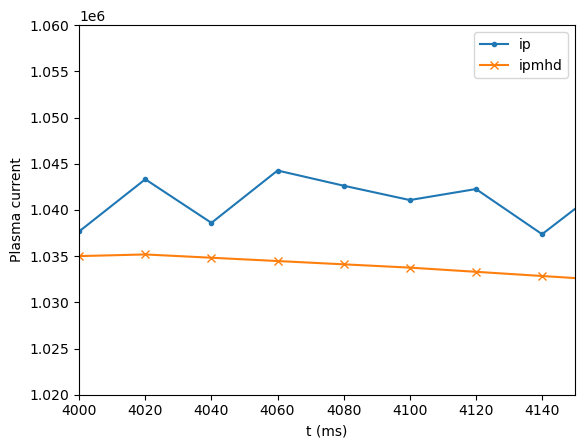

In [11]:
pipeline = create_pipeline()
pipeline.align('ds', 'ip', method='linear')
compute_and_plot(pipeline, xlim=(4000,4150), ylim=(1.02e6, 1.06e6))

### Aligning with ```ipmhd``` instead of ```ip```

<xarray.Dataset> Size: 920B
Dimensions:  (shot: 1, times: 76)
Coordinates:
  * shot     (shot) int64 8B 165920
  * times    (times) float32 304B 100.0 200.0 280.0 ... 6.26e+03 6.34e+03
Data variables:
    ip       (times) float32 304B 2.109e+05 2.883e+05 ... 4.839e+05 4.763e+05
    ipmhd    (times) float32 304B 2.135e+05 2.907e+05 ... 4.821e+05 4.753e+05


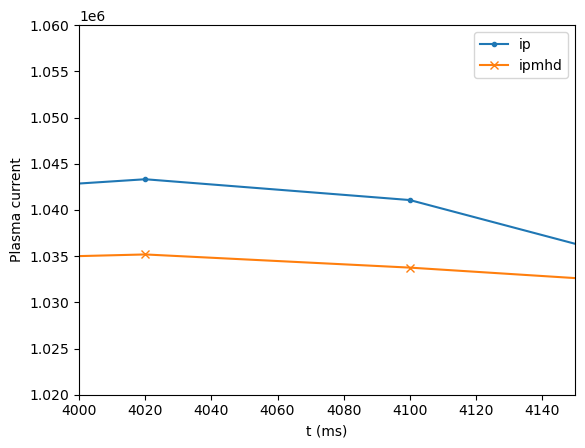

In [12]:
pipeline = create_pipeline()
pipeline.align('ds', 'ipmhd', method='linear')
compute_and_plot(pipeline, xlim=(4000,4150), ylim=(1.02e6, 1.06e6))

Note that by aligning with ```ipmhd```, we've effectively downsampled ```ip```.

### Aligning to a predetermined timebase

The second argument to the ```align``` method will accept a list-like object or numpy array as input and coerce all the signals in the dataset to use that as its timebase.

<xarray.Dataset> Size: 176B
Dimensions:  (shot: 1, times: 7)
Coordinates:
  * shot     (shot) int64 8B 165920
  * times    (times) int64 56B 4000 4025 4050 4075 4100 4125 4150
Data variables:
    ip       (times) float64 56B 1.038e+06 1.042e+06 ... 1.041e+06 1.04e+06
    ipmhd    (times) float64 56B 1.035e+06 1.035e+06 ... 1.033e+06 1.033e+06


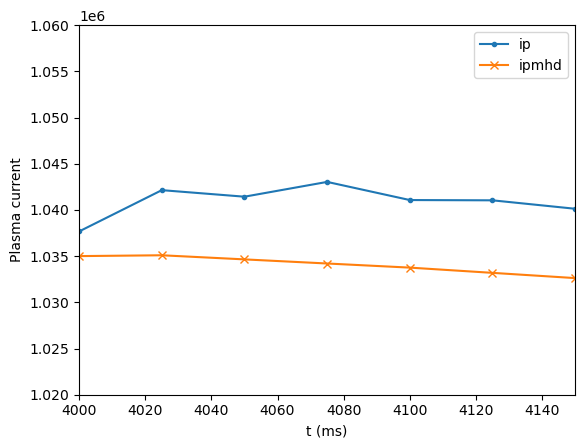

In [14]:
pipeline = create_pipeline()
pipeline.align('ds', [4000, 4025, 4050, 4075, 4100, 4125, 4150], method='linear')
compute_and_plot(pipeline, xlim=(4000,4150), ylim=(1.02e6, 1.06e6))

### Aligning to a timebase determined by a user-defined function

The second argument to ```align``` additionally accepts a callback function as an argument. This function must take a dataset as an input and return a list-like object (including numpy arrays) as a return value.

<xarray.Dataset> Size: 104B
Dimensions:  (shot: 1, times: 8)
Coordinates:
  * shot     (shot) int64 8B 165920
  * times    (times) float32 32B 4e+03 4.02e+03 4.04e+03 ... 4.12e+03 4.14e+03
Data variables:
    ip       (times) float32 32B 1.038e+06 1.043e+06 ... 1.042e+06 1.037e+06
    ipmhd    (times) float32 32B 1.035e+06 1.035e+06 ... 1.033e+06 1.033e+06


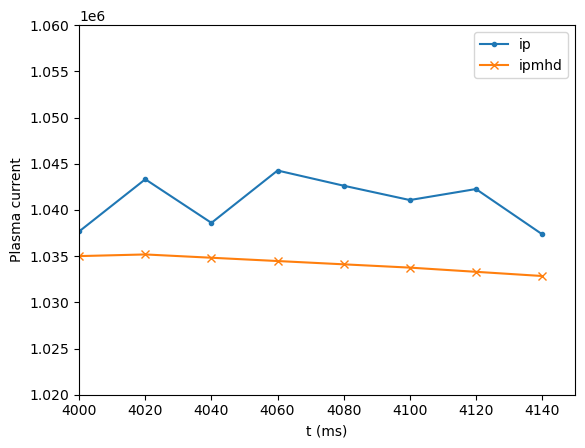

In [15]:
def custom_timebase(ds):
    condition = (ds.times >= 4000) & (ds.times <= 4150)
    return ds.times.where(condition, drop=True)

pipeline = create_pipeline()
pipeline.align('ds', custom_timebase, method='linear')
compute_and_plot(pipeline, xlim=(4000,4150), ylim=(1.02e6, 1.06e6))